In [1]:
import torch
import torch.nn as nn
from utils import create_bbox_mask
from torch.utils.data import DataLoader
from torchvision import transforms
transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
from data_loader.data_loaders import CocoDataset, collate_fn
from model.model import *

BATCH_SIZE = 128
seed = 42
torch.manual_seed(seed)
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
print(device)
model = FeatureSynthesisModel()
model = model.to(device)
model.load_state_dict(torch.load('saved/models/masking_l2norm/0829_172712/checkpoint-epoch50.pth')['state_dict'])
backbone_model = ResNet50()

model.eval()  # set to evaluation mode
backbone_model = backbone_model.to(device)
backbone_model.eval()  # set to evaluation mode






cuda:1


/home/mmlab/anaconda3/envs/bbir/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mmlab/anaconda3/envs/bbir/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet50(
  (resnet50): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64

In [2]:
train_set = CocoDataset(root='./data/coco', mode='val2017', transform=transforms)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, collate_fn=collate_fn)
test = next(iter(train_loader))
imgs, canvas_queries, queries = test
imgs = imgs.to(device)
canvas_queries = canvas_queries.to(device)
query_ids = queries[3]


In [3]:
output_feature = model(canvas_queries)
target_feature = backbone_model(imgs)

# Create a mask tensor for the entire batch
masks = torch.stack([create_bbox_mask(queries[1][i], 7) for i in range(BATCH_SIZE)]).to(device)
masks = masks.unsqueeze(1)  # Add channel dimension: [batch_size, 1, 7, 7]
# target_feature = target_feature * masks
# output_feature = output_feature * masks
# target_feature = target_feature.detach().cpu().numpy()
# output_feature = output_feature.detach().cpu().numpy()

In [6]:
# perform nearest neighbor search
from sklearn.neighbors import NearestNeighbors
from PIL import Image
import numpy as np

query_ids = queries[3]
gt = np.array(queries[3])
# print(query_ids)
all_img_features = []

for i in range(output_feature.shape[0]):
    output = output_feature[i] * masks[i] # [2048, 7, 7]
    output = output.detach().cpu().numpy()
    target_list = []
    for j in range(target_feature.shape[0]):
        target = target_feature[j] * masks[j] # [2048, 7, 7]
        target = target.detach().cpu().numpy()
        # append each target with [2048, 7, 7] to the list to form [n, 2048, 7, 7]
        target_list.append(target)
    target_list = np.stack(target_list) # [n, 2048, 7, 7]
    target_list = target_list.reshape(target_list.shape[0], -1) # [n, 2048 * 49]
    # output = output.reshape(2048, 7, 7)
    # output = output.transpose(1, 2, 0)
    print(target_list.shape)
    nbrs = NearestNeighbors(n_neighbors=5, algorithm='brute', metric='cosine').fit(target_list) 
    distances, indices = nbrs.kneighbors(output.reshape(1, -1))
    print(indices)
nbrs = NearestNeighbors(n_neighbors=1, algorithm='brute', metric='cosine').fit(target_list) 
distances, indices = nbrs.kneighbors(output_feature) 
indices = indices.reshape(-1)
# print(indices)
distances = distances.reshape(-1)
query_ids = np.array(query_ids)
query_ids = query_ids[indices]
distances = distances[indices]

(128, 100352)
[[  0  29 126  70  21]]
(128, 100352)
[[ 1 28 56 12 42]]
(128, 100352)
[[  2  90   9  71 112]]
(128, 100352)
[[ 3  6 65 93 66]]
(128, 100352)
[[  4  42  52  56 102]]
(128, 100352)
[[ 16   5 103 122  63]]
(128, 100352)
[[  6   3 104  93  79]]
(128, 100352)
[[  7  32 125  72  24]]
(128, 100352)
[[120   8 114  25  98]]
(128, 100352)
[[  9  90  71  93 104]]
(128, 100352)
[[ 10 115  29  21 123]]
(128, 100352)
[[11 15 14 57 39]]
(128, 100352)
[[ 12  56   1 112  49]]
(128, 100352)
[[13 33 53 88 48]]
(128, 100352)
[[14 11 57 49  4]]
(128, 100352)
[[15 39 11 55 89]]
(128, 100352)
[[ 16   5 103 122  63]]
(128, 100352)
[[ 17 117 102  21 110]]
(128, 100352)
[[ 47  18  78 123  86]]
(128, 100352)
[[ 19 114   8  87  30]]
(128, 100352)
[[ 20  35  39 118 127]]
(128, 100352)
[[ 21  52  97  10 123]]
(128, 100352)
[[ 22  98   3 104  73]]
(128, 100352)
[[ 23   2  90 109  24]]
(128, 100352)
[[ 24 125  48  92  28]]
(128, 100352)
[[ 16 103  25 110   5]]
(128, 100352)
[[26 83 41  0 58]]
(128, 100

TypeError: can't convert cuda:1 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [33]:
import matplotlib.pyplot as plt
def visualize_sum(canvas_query):
    summed_image = canvas_query.sum(dim=0)
    print(summed_image.shape)
    summed_image = torch.ones((31, 31)) - summed_image
    # reverse the color channels
    # plot size is 10 inches by 10 inches
    plt.figure(figsize=(5, 5))
    plt.imshow(summed_image, cmap='gray')
    plt.title('Canvas Query')
    # plt.axis('off')
    plt.savefig('canvas_query.png')
    plt.show()



[101891, 463176, 298347, 246181, 9296, 403074, 215863, 243464, 164093, 521184, 510756, 125394, 90509, 307794, 170888, 93411, 125639, 302108, 517031, 26981, 456190, 71159, 43936, 171012, 501388, 6847, 428412, 185302, 388398, 311583, 543836, 565227]
[101891 463176 298347 246181   9296 403074 215863 243464 164093 521184
 510756 125394  90509 307794 170888  93411  26981 302108 517031  26981
 125639  71159  43936 171012 501388 125639 428412 185302 388398 311583
 543836 565227]
[0.34850055 0.4426754  0.30742812 0.17858022 0.30294842 0.39514863
 0.5185952  0.46645612 0.37385654 0.35480124 0.35425705 0.27098495
 0.408351   0.35822737 0.40786642 0.29073745 0.4003206  0.36984205
 0.4001962  0.4003206  0.4003206  0.29262155 0.27247393 0.24923587
 0.39465564 0.4003206  0.4200325  0.27658623 0.37986732 0.3571996
 0.38396603 0.43802685]
num correct :  29
torch.Size([31, 31])


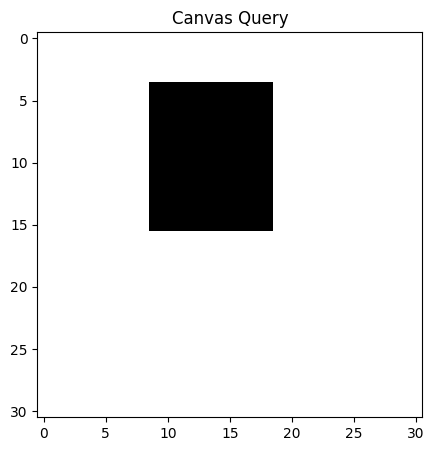

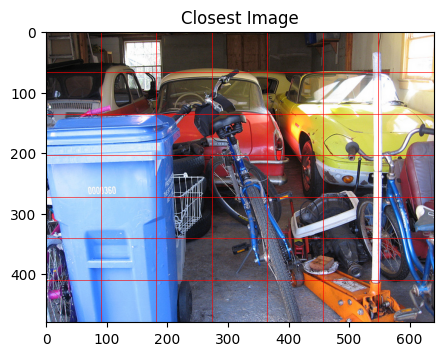

In [34]:
# perform nearest neighbor search
from sklearn.neighbors import NearestNeighbors
from PIL import Image
import numpy as np

query_ids = queries[3]
gt = np.array(queries[3])
print(query_ids)
target_feature = target_feature.reshape(target_feature.shape[0], -1)
output_feature = output_feature.reshape(output_feature.shape[0], -1)
nbrs = NearestNeighbors(n_neighbors=1, algorithm='brute', metric='cosine').fit(target_feature)
distances, indices = nbrs.kneighbors(output_feature)
indices = indices.reshape(-1)
# print(indices)
distances = distances.reshape(-1)
query_ids = np.array(query_ids)
query_ids = query_ids[indices]
distances = distances[indices]
print(query_ids)
print(distances)
print('num correct : ', np.sum(query_ids == gt))
visualize_sum(canvas_queries[0].detach().cpu())
import os
image = Image.open(os.path.join(train_set.train_img_path, "{:012}".format(query_ids[0]) + '.jpg'))
#resize image to 31x31
# image = image.resize((31, 31))
plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.title('Closest Image')
# plt.axis('off')
plt.savefig('closest_image.png')
plt.show()

/home/mmlab/anaconda3/envs/bbir/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mmlab/anaconda3/envs/bbir/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


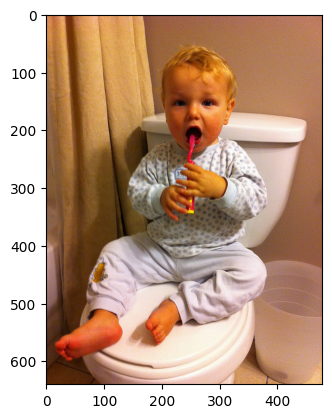

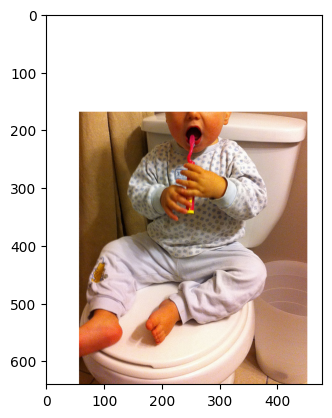

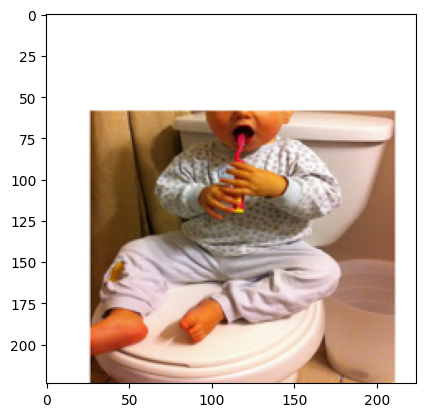

torch.Size([1, 2048, 7, 7])

In [45]:
from torchvision.models import resnet50
from PIL import Image, ImageDraw
import torch, torchvision
import matplotlib.pyplot as plt

model = resnet50(pretrained=True)
model = torch.nn.Sequential(*(list(model.children())[:-2]))
img_path = './data/coco/val2017/images/000000368212.jpg'
img = Image.open(img_path)
plt.imshow(img)
plt.show()
mask = Image.new('L', img.size, 0)
draw = ImageDraw.Draw(mask)
min_x, min_y, w, h = 57.97, 169.02, 392.72, 470.98
# min_x, min_y, w, h = 1.0, 1.0, 639.0, 417.96
# 57.97,
#                     169.02,
#                     392.72,
#                     470.98
max_x, max_y = min_x + w, min_y + h
draw.rectangle([min_x, min_y, max_x, max_y], fill=255)

result = Image.composite(img, Image.new('RGB', img.size, (255, 255, 255)), mask)
plt.imshow(result)
plt.show()
img = result.resize((224, 224))
plt.imshow(img)
plt.show()
img_tensor = torchvision.transforms.ToTensor()(img)
img_tensor = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img_tensor)
model.eval()
pred = model(img_tensor.unsqueeze(0))
pred.shape

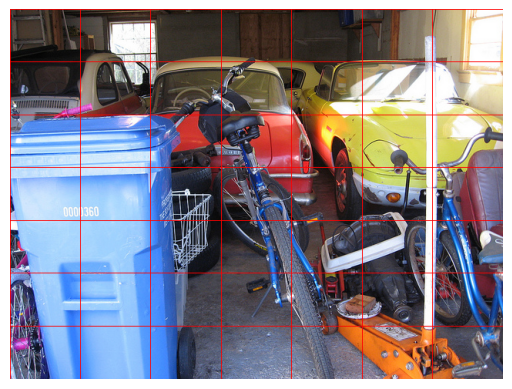

In [37]:
from PIL import Image, ImageDraw
img_path = './data/coco/train/images/000000101891.jpg'
img = Image.open(img_path)
draw = ImageDraw.Draw(img)
width, height = img.size
x_spacing = width / 7
y_spacing = height / 7
for i in range(8):
    x = int(x_spacing * i)
    draw.line([(x, 0), (x, height)], fill='red')
for i in range(8):
    y = int(y_spacing * i)
    draw.line([(0, y), (width, y)], fill='red')

plt.imshow(img)
plt.axis('off')
plt.show()

In [35]:
import json
query_path = './data/coco/train/query.json'
with open(query_path, 'r') as f:
    query = json.load(f)
label_path = './data/coco/labels.txt'
with open(label_path, 'r') as f:
    labels = f.read().split('\n')

count_labels = {}
for q in query:
    label = q['layout']['category']
    if label not in count_labels:
        count_labels[label] = 0
    count_labels[label] += 1
print(len(query))

69837
